In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os, shutil
import keras
from keras import layers, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D,MaxPooling2D, Dropout, Dense, BatchNormalization, Flatten
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
from keras.optimizers import Nadam

import tensorflow as tf
tf.set_random_seed(0)

import matplotlib.pyplot as plt 
from glob import glob
%matplotlib inline

np.random.seed(101)

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
os.listdir('../input/')

['train', 'test', 'train_labels.csv', 'sample_submission.csv']

In [3]:
train_dir = '../input/train/'
data = pd.DataFrame({'path': glob(os.path.join(train_dir,'*.tif'))                    
                    })
data.head()


,path
0,../input/train/292faf631c5ff5741bb46b04e4eacce...
1,../input/train/5a61b93a34e2a37869a4e83e964169a...
2,../input/train/139e7bd057aafacf7cce59490104ccf...
3,../input/train/5adf6b5ce28b15f585b8d53fc8d3716...
4,../input/train/abf7a7eb3e7bc917e766670eebd7f44...


In [4]:
data['id'] = data.path.apply(lambda x: str(x).split('/')[3].split('.')[0])
data.head()

,path,id
0,../input/train/292faf631c5ff5741bb46b04e4eacce...,292faf631c5ff5741bb46b04e4eacceb272d8c8b
1,../input/train/5a61b93a34e2a37869a4e83e964169a...,5a61b93a34e2a37869a4e83e964169ad3d1e3753
2,../input/train/139e7bd057aafacf7cce59490104ccf...,139e7bd057aafacf7cce59490104ccf281a3fa98
3,../input/train/5adf6b5ce28b15f585b8d53fc8d3716...,5adf6b5ce28b15f585b8d53fc8d3716182026ab4
4,../input/train/abf7a7eb3e7bc917e766670eebd7f44...,abf7a7eb3e7bc917e766670eebd7f440c500ee4d


In [5]:
df = pd.read_csv('../input/train_labels.csv')
data = data.merge(df, on='id')
data.head()

,path,id,label
0,../input/train/292faf631c5ff5741bb46b04e4eacce...,292faf631c5ff5741bb46b04e4eacceb272d8c8b,0
1,../input/train/5a61b93a34e2a37869a4e83e964169a...,5a61b93a34e2a37869a4e83e964169ad3d1e3753,0
2,../input/train/139e7bd057aafacf7cce59490104ccf...,139e7bd057aafacf7cce59490104ccf281a3fa98,0
3,../input/train/5adf6b5ce28b15f585b8d53fc8d3716...,5adf6b5ce28b15f585b8d53fc8d3716182026ab4,0
4,../input/train/abf7a7eb3e7bc917e766670eebd7f44...,abf7a7eb3e7bc917e766670eebd7f440c500ee4d,0


In [6]:
training_dir= '../training_dir'
validation_dir= '../validation_dir'
os.mkdir(training_dir)
os.mkdir(validation_dir)

In [7]:
df = data
df_0 = df[df.label==0]
df_1 = df[df.label==1]
df_1.head()

,path,id,label
5,../input/train/156f6a50526bdfdfae44a804c6fabce...,156f6a50526bdfdfae44a804c6fabce6562482e0,1
7,../input/train/b2b1c081319ac56e011bfe368fb3033...,b2b1c081319ac56e011bfe368fb30336fa1ddce1,1
8,../input/train/f2f7753410bd17f63f1fb6570e2614d...,f2f7753410bd17f63f1fb6570e2614d6092c2754,1
13,../input/train/21133e327d174c4f92d1ff9eaa905de...,21133e327d174c4f92d1ff9eaa905de4ef298a85,1
15,../input/train/5474ab5628a0875c5473b7b3239dc0a...,5474ab5628a0875c5473b7b3239dc0a94efcf3ea,1


In [8]:
print(df_1.shape)
df_0.shape

(89117, 3)


(130908, 3)

In [9]:
categories = [0,1]
for category in categories:
    os.mkdir(os.path.join(training_dir,str(category))) #../training_dir/0 or 1
    os.mkdir(os.path.join(validation_dir,str(category)))
    
 # CREATING TRAINING DIRECTORY            
for category in categories:
    cdir= os.path.join(training_dir,str(category)) #creates '../1 or 0'
    for sample_count, path in enumerate(df[df.label ==category].path):
        id = path.split('/')[3] #generate destination id_name
        src = path
        dst = os.path.join(cdir,id) #destination
        shutil.copyfile(src,dst)
        if sample_count==70000: break
        


In [10]:
#CREATING VALIDATION DIRECTORY
for category in categories:
    cdir= os.path.join(validation_dir,str(category)) #creates '../1 or 0'
    for sample_count, path in enumerate(df[df.label ==category].path):
        if sample_count>70000:
            id = path.split('/')[3] #generate destination id_name
            src = path
            dst = os.path.join(cdir,id) #destination
            shutil.copyfile(src,dst)
            if sample_count==89000: break
        else: continue

In [11]:
len(os.listdir(os.path.join(validation_dir,'1')))

19000

In [12]:
os.listdir(validation_dir)

['1', '0']

In [13]:
data_gen = ImageDataGenerator(rotation_range=40,
                          rescale=1./255, width_shift_range=0.2, 
                              height_shift_range=0.2, 
                             shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True,
                             fill_mode='nearest')

In [14]:
batch_size=20
train_generator = data_gen.flow_from_directory(training_dir, 
                                               target_size=(96,96),
                                               class_mode='binary',
                                               batch_size=batch_size)
test_gen = ImageDataGenerator(rescale=1./255)

validation_generator_shuffled=test_gen.flow_from_directory(validation_dir,
                                                 target_size=(96,96),
                                                 class_mode='binary',
                                                 batch_size=batch_size)

validation_generator=test_gen.flow_from_directory(validation_dir,
                                                 target_size=(96,96),
                                                 class_mode='binary',
                                                 batch_size=batch_size,
                                                 shuffle=False)



Found 140002 images belonging to 2 classes.
Found 38000 images belonging to 2 classes.
Found 38000 images belonging to 2 classes.


In [15]:
pool_size= (2,2)

model = Sequential()
model.add(layers.Conv2D(32,3,input_shape=(96,96,3), activation='relu'))
model.add(layers.Conv2D(32,3,activation='relu'))
model.add(layers.Conv2D(32,3,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size))
# model.add(Dropout(0.3))

model.add(layers.Conv2D(64,3,activation='relu'))
model.add(layers.Conv2D(64,3,activation='relu'))
model.add(layers.Conv2D(64,3,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size))
# model.add(Dropout(0.3))

model.add(layers.Conv2D(128,3,activation='relu'))
model.add(layers.Conv2D(128,3,activation='relu'))
model.add(layers.Conv2D(128,3,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size))
# model.add(Dropout(0.3))

model.add(layers.Conv2D(256,3,activation='relu', padding='same'))
model.add(layers.Conv2D(256,3,activation='relu', padding='same'))
model.add(layers.Conv2D(256,3,activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size))
# model.add(Dropout(0.3))

model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))


In [16]:
model.compile(optimizer=optimizers.Nadam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 64)        36928     
__________

In [17]:
train_samples = 140000
checkpoint_name= '../working/model.h5'
checkpoint = ModelCheckpoint(checkpoint_name, save_best_only=True)
stop = EarlyStopping(patience=10, verbose=1)
LrReduce = ReduceLROnPlateau(verbose=1, patience=4)
model.fit_generator(train_generator, 
                    steps_per_epoch=train_samples//batch_size,
                   validation_data=validation_generator_shuffled,
                   epochs=20,
                   callbacks=[checkpoint,stop, LrReduce])

Epoch 1/20
6408/7000 [==========================>...] - ETA: 1:00 - loss: 0.4778 - acc: 0.7817

In [18]:
history = model.history.history

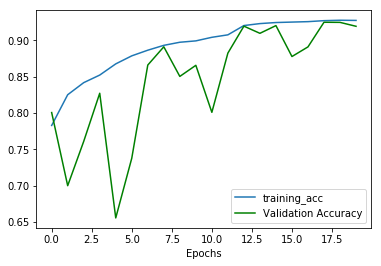

In [19]:
plt.plot(model.history.epoch, history['acc'],label='training_acc')
plt.plot(model.history.epoch, history['val_acc'],c='green', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()


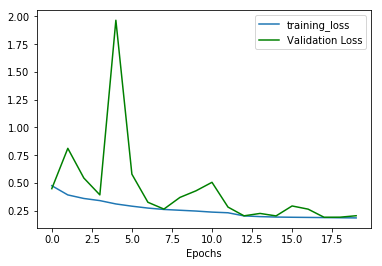

In [20]:
plt.plot(model.history.epoch, history['loss'],label='training_loss')
plt.plot(model.history.epoch, history['val_loss'],c='green', label='Validation Loss')
plt.xlabel('Epochs')
plt.legend()

In [21]:
os.listdir('../working')

['__notebook__.ipynb', '__output__.json', 'model.h5']

In [22]:
from keras.models import load_model
predictor = load_model(checkpoint_name)

In [23]:
validation_generator.filenames[:5]

['0/000020de2aa6193f4c160e398a8edea95b1da598.tif',
 '0/0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.tif',
 '0/00011545a495817817c6943583b294c900a137b8.tif',
 '0/00030ae10b490d6f1b114bd7ea7a222889e61baa.tif',
 '0/0003bc63342dd32164456c537a14d7906e18eb69.tif']

In [24]:
test_dir = '../input/test/'
df_test = pd.DataFrame({'path': glob(os.path.join(test_dir,'*.tif'))                    
                    })
df_test['id'] = df_test.path.apply(lambda x: str(x).split('/')[3].strip())
# df_test.drop('path', axis=1, inplace=True)
df_test.head()


,path,id
0,../input/test/0eb051700fb6b1bf96188f36c8e48895...,0eb051700fb6b1bf96188f36c8e4889598c6a157.tif
1,../input/test/c99d6bc4cee9df4c93a0c3f4138664db...,c99d6bc4cee9df4c93a0c3f4138664db59e1e6ef.tif
2,../input/test/2859428095a9d1e6aba4bc135c69b596...,2859428095a9d1e6aba4bc135c69b59693b6d02a.tif
3,../input/test/13141967dff006e2e3f65282a02d3faf...,13141967dff006e2e3f65282a02d3faf46ec038f.tif
4,../input/test/ad15cf4e12c953fd5822eec528c55a54...,ad15cf4e12c953fd5822eec528c55a54fccaeae8.tif


In [25]:
test_batch_size=2
test_generator = test_gen.flow_from_dataframe(df_test,directory='../input/test/',x_col='id',
                                              target_size=(96,96),class_mode=None,
                                             shuffle=False,
                                             batch_size=test_batch_size)

Found 57458 images.


In [26]:
df_test.drop('path', inplace=True, axis=1)
df_test.id = test_generator.filenames
df_test.head()

,id
0,00006537328c33e284c973d7b39d340809f7271b.tif
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,000270442cc15af719583a8172c87cd2bd9c7746.tif


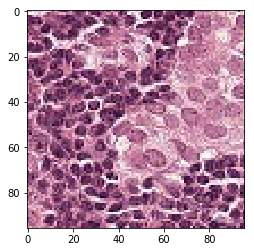

In [27]:
for bb in test_generator:
    plt.imshow(bb[0])
    break

In [28]:
no_of_samples = 57458
predictions = predictor.predict_generator(test_generator,
                                         steps=no_of_samples//test_batch_size, verbose=1)

28729/28729 [==============================] - 147s 5ms/step


In [29]:
df_test.head()

,id
0,00006537328c33e284c973d7b39d340809f7271b.tif
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,000270442cc15af719583a8172c87cd2bd9c7746.tif


In [30]:
predictions

array([[0.9990121 ],
       [0.8035337 ],
       [0.8656497 ],
       ...,
       [0.00175404],
       [0.54328007],
       [0.09879   ]], dtype=float32)

In [31]:
results = pd.DataFrame({'label': predictions.reshape(-1,)}, index=range(0,no_of_samples))
results.head()

,label
0,0.999012
1,0.803534
2,0.865650
3,0.045618
4,0.013802


In [32]:
# def ro(x):
#     if x>=0.5: x=1
#     else: x=0
#     return x

dd = results
dd.label = dd.label.apply(round)
dd.label.value_counts()

0    38824
1    18634
Name: label, dtype: int64

In [33]:
results = pd.DataFrame({'label': predictions.reshape(-1,)}, index=range(0,no_of_samples))
results.head()

,label
0,0.999012
1,0.803534
2,0.865650
3,0.045618
4,0.013802


In [34]:
# df_test.drop('path', axis=1, inplace=True)
df_test.id = df_test.id.apply(lambda x: x.split('.')[0])
df_test.head()

,id
0,00006537328c33e284c973d7b39d340809f7271b
1,0000ec92553fda4ce39889f9226ace43cae3364e
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,000270442cc15af719583a8172c87cd2bd9c7746


In [35]:
submission = pd.concat([df_test,results],axis=1)
# submission2 = pd.concat([df_test,dd],axis=1)
submission.head(10)

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.999012
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.803534
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.865650
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.045618
4,000270442cc15af719583a8172c87cd2bd9c7746,0.013802
5,000309e669fa3b18fb0ed6a253a2850cce751a95,0.305009
6,000360e0d8358db520b5c7564ac70c5706a0beb0,0.002411
7,00040095a4a671280aeb66cb0c9231e6216633b5,0.135766
8,000698b7df308d75ec9559ef473a588c513a68aa,0.913441
9,0006e1af5670323331d09880924381d67d79eda0,0.754808


In [36]:
submission.to_csv('submissions.csv', index=False)
# submission2.to_csv('submissionswhole.csv', index=False)

In [37]:
pd.read_csv('submissions.csv').head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.999012
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.803534
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.865650
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.045618
4,000270442cc15af719583a8172c87cd2bd9c7746,0.013802


In [38]:
# def roundup(x):
#     if x>=0.5: x = 1
#     else: x=0
#     return x

In [39]:
# results.label.apply(roundup).value_counts()

In [40]:
# val_batch_labels=np.zeros(len(validation_generator.classes))

In [41]:
# i = 0
# for b, l in (validation_generator):
#     val_batch_labels[i*batch_size:batch_size*(i+1)] = l
#     i+=1
#     if i==3000:
#         break

In [42]:
# print('done')
# pd.DataFrame(val_batch_labels)[0].value_counts()

In [43]:

from sklearn.metrics import roc_curve,auc, confusion_matrix, classification_report
val_pred = predictor.predict_generator(validation_generator,
                                      steps=len(validation_generator.classes)//batch_size,
                                      verbose=1)

1900/1900 [==============================] - 41s 21ms/step


In [44]:
val_pred

array([[0.03567059],
       [0.01097356],
       [0.06024702],
       ...,
       [0.9762646 ],
       [0.93746346],
       [0.01184475]], dtype=float32)

In [45]:
false_positive_rate,true_positive_rate,threshold = roc_curve(validation_generator.classes,
                                                            val_pred)

In [46]:
val_pred_whole = np.where(val_pred>=0.5,1,0)
AUC = auc(false_positive_rate,true_positive_rate)
print(AUC)
print(classification_report(validation_generator.classes,val_pred_whole))

0.9781468310249307
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     19000
           1       0.95      0.89      0.92     19000

   micro avg       0.92      0.92      0.92     38000
   macro avg       0.93      0.92      0.92     38000
weighted avg       0.93      0.92      0.92     38000



In [47]:
dg = pd.DataFrame(val_pred_whole, columns=['label'])
dg.label.value_counts()

0    20240
1    17760
Name: label, dtype: int64

In [48]:
validation_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [49]:
shutil.rmtree(validation_dir)
